In [ ]:
from src.dataset.tornado_reflectivity import TornadoReflectivityDataset


dataset = TornadoReflectivityDataset()

🌪️ Loading tornado events from cache:   0%|          | 0/2141 [00:00<?, ?it/s]

Error: list index out of range


🌪️ Loading tornado events from cache: 100%|██████████| 2141/2141 [01:19<00:00, 27.03it/s]


In [ ]:
import matplotlib.pyplot as plt
import numpy as np


item = dataset[88]
source = item['source'][0, ...]
target = item['target'][0, ...]
source.shape, target.shape

(torch.Size([224, 224]), torch.Size([224, 224]))

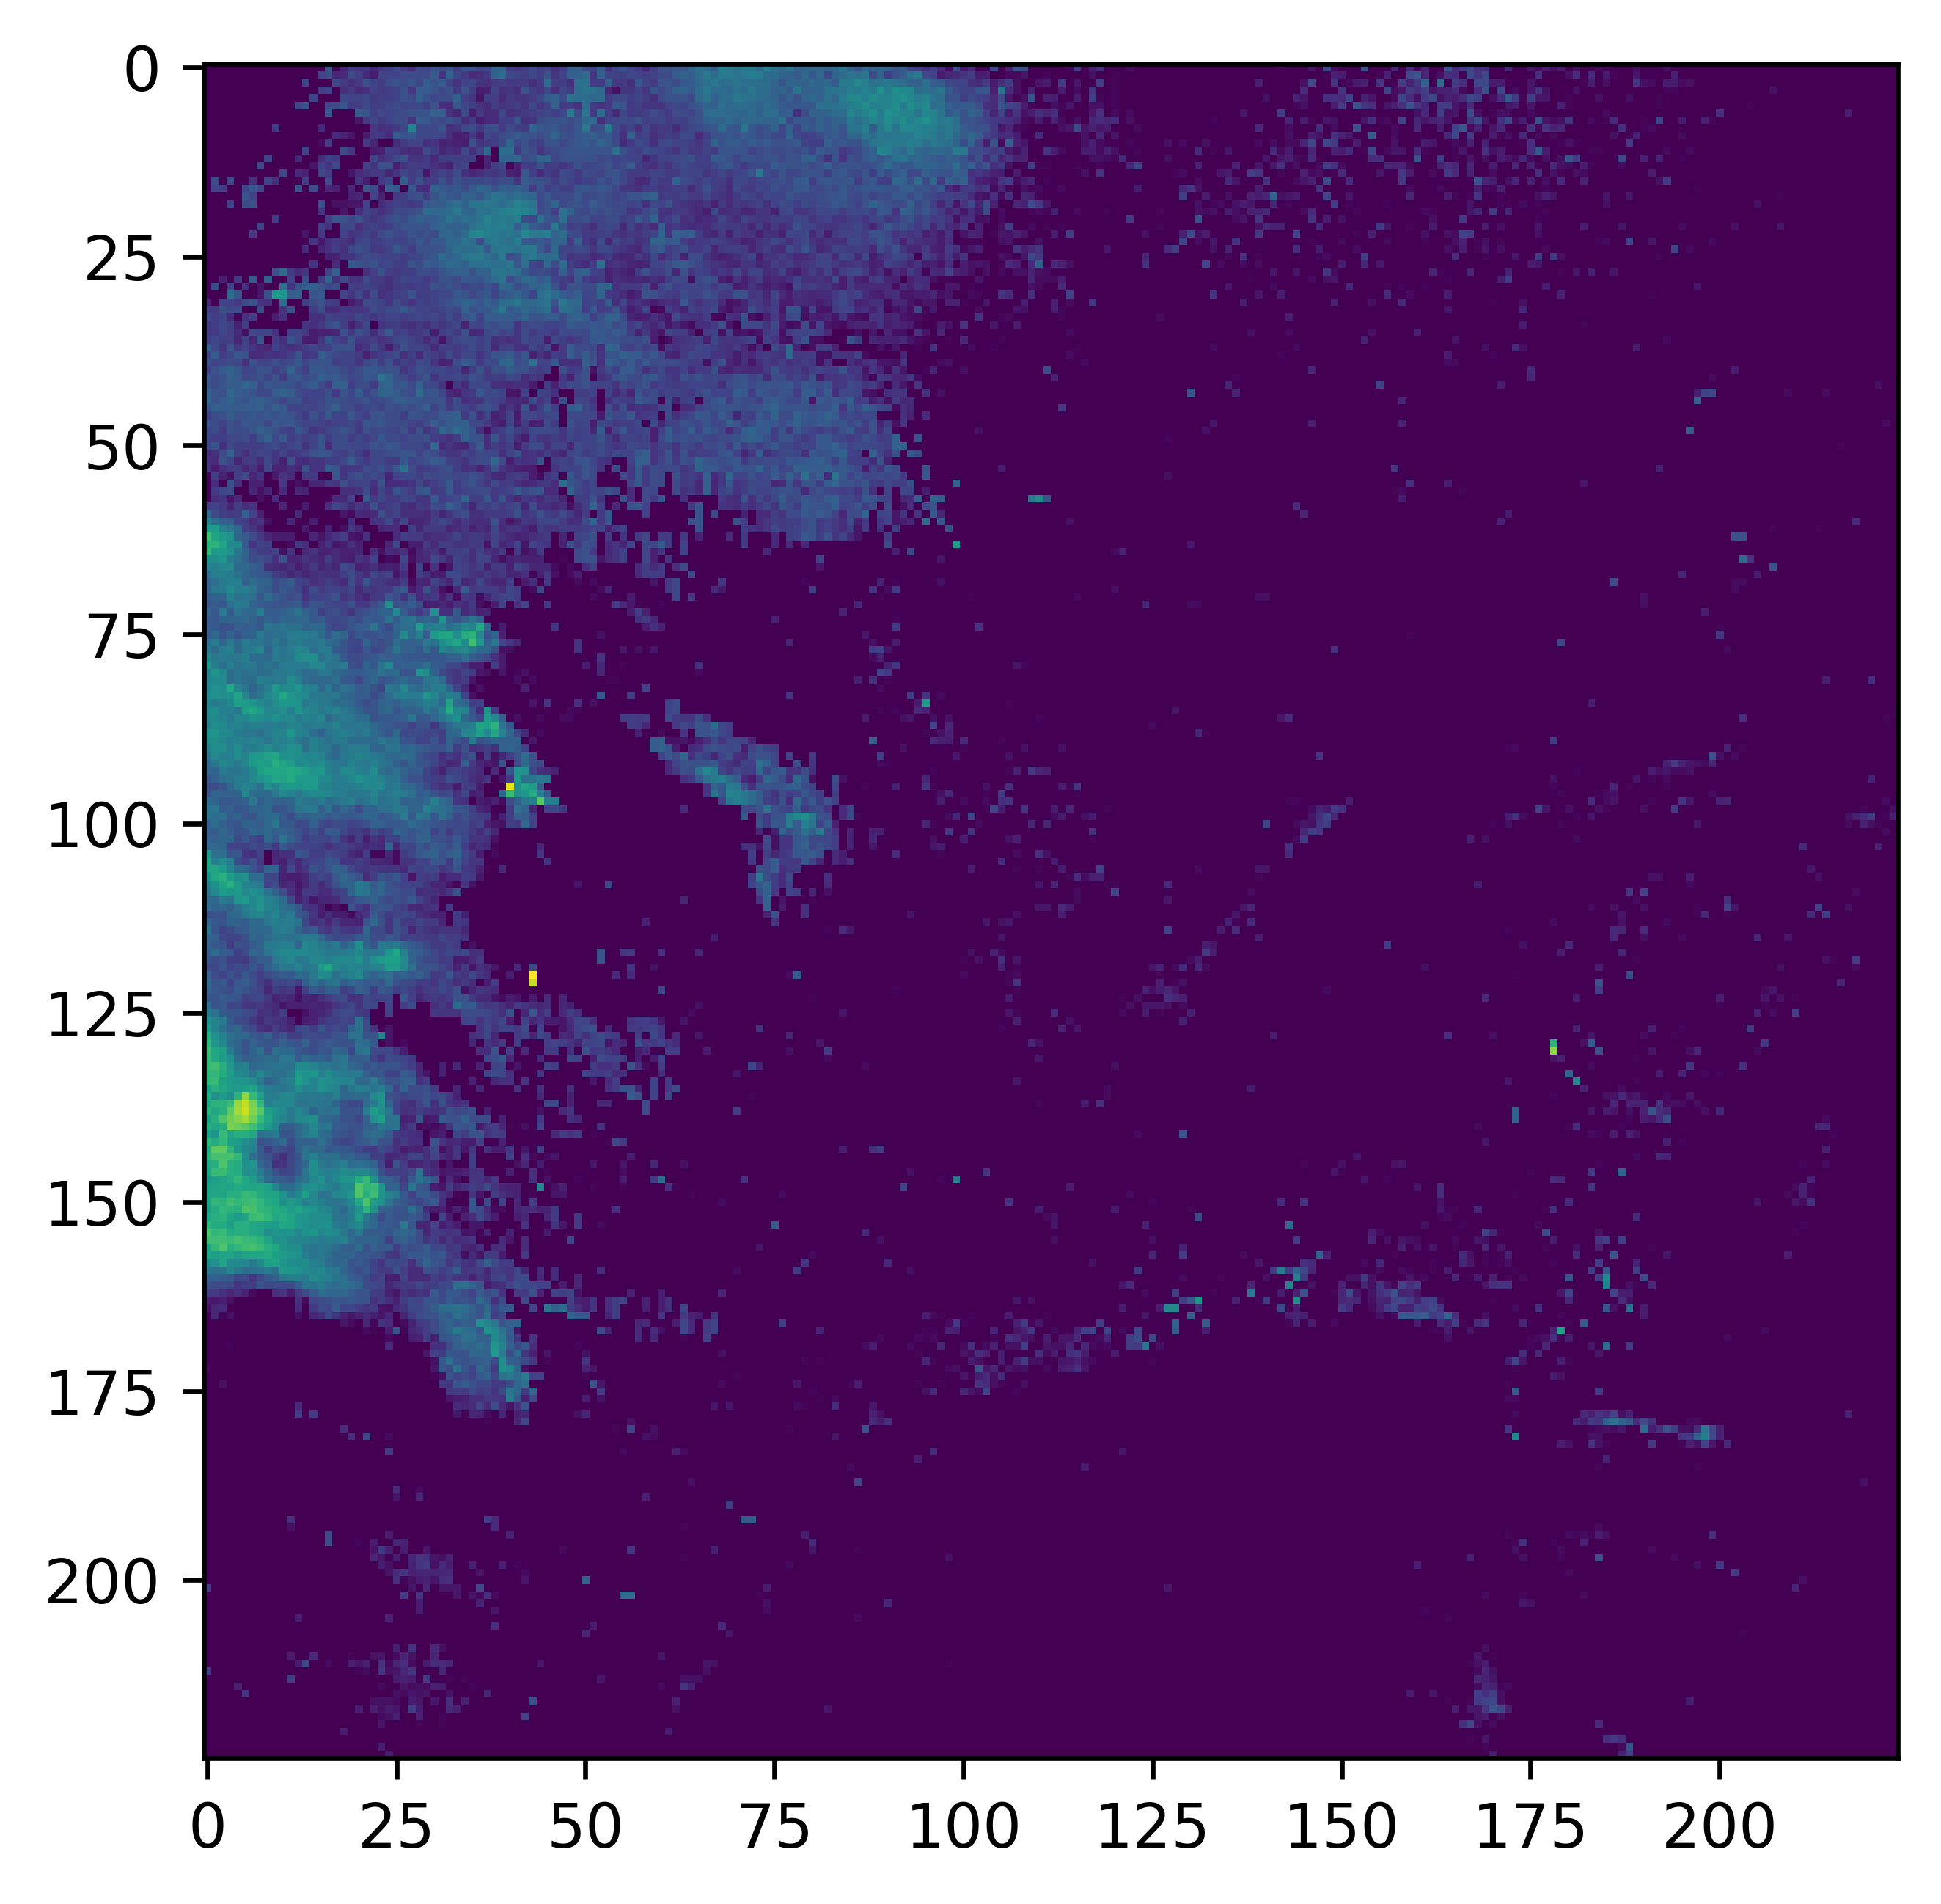

In [ ]:
source = target.clip(0) / target.max()
plt.figure(figsize=(10, 5), dpi=600)
plt.imshow(source);

# MRMS Client Testing

In [ ]:
"""
# Sources
---
- https://github.com/NOAA-National-Severe-Storms-Laboratory/mrms-support
- https://training.weather.gov/wdtd/courses/MRMS/lessons/overview-v12.2/presentation_html5.html
- https://github.com/HumphreysCarter/mrms-api

# Dataset Structure
---
- DOMAIN
    - PRODUCT
        - YYYYMMDD
            - PRODUCT_YYYYMMDD-ZZZZZZ.grib2.gz
"""

import xarray
import subprocess

from pathlib import Path
from s3fs import S3FileSystem


class MRMSAWSClient:
    """
    A high-level python API for the AWS MRMS S3 bucket.
    """

    BASE_URL_CONUS = "s3://noaa-mrms-pds/CONUS/"

    def __init__(self, format="NCEP"):

        # create an anonymous fs
        self.s3_file_system = S3FileSystem(anon=True)

    def download(self, path: str, to: str, recursive=False):

        assert self.s3_file_system.exists(path), f"Error! Invalid path: {path}"
        assert Path(to).is_dir(), f"Error! 'To' not a valid dir: {to}"

        # TODO:
        # if  : recursive is true than path msut always be a dir
        # else: path must be a file + file name must be appended to end of "to"

        # try to download files -> "to"
        cmd = ["aws", "s3", "cp", "--no-sign-request",path, str(to)]
        if recursive:
            cmd.append("--recursive")

        result = subprocess.run(cmd, capture_output=True, text=True)
        if result.returncode != 0:
            raise RuntimeError(f"Download failed:\nSTDOUT: {result.stdout}\nSTDERR: {result.stderr}")
        else:
            print(f"✅ Download complete:\n{result.stdout}")

    def get(url: str): pass

In [18]:
client = MRMSAWSClient()

url = "s3://noaa-mrms-pds/CONUS/BREF_1HR_MAX_00.50/20201014/"
out_dir = "/playpen/mufan/levi/tianlong-chen-lab/torp-v2/mrms-radar-evolution/___old___/_test"
client.download(url, out_dir, recursive=True)

✅ Download complete:
Completed 256.0 KiB/2.2 MiB (903.5 KiB/s) with 2 file(s) remaining
Completed 512.0 KiB/2.2 MiB (1.7 MiB/s) with 2 file(s) remaining  
Completed 768.0 KiB/2.2 MiB (2.5 MiB/s) with 2 file(s) remaining  
Completed 1.0 MiB/2.2 MiB (3.1 MiB/s) with 2 file(s) remaining    
Completed 1.2 MiB/2.2 MiB (3.9 MiB/s) with 2 file(s) remaining    
Completed 1.3 MiB/2.2 MiB (4.1 MiB/s) with 2 file(s) remaining    
Completed 1.6 MiB/2.2 MiB (4.9 MiB/s) with 2 file(s) remaining    
download: s3://noaa-mrms-pds/CONUS/BREF_1HR_MAX_00.50/20201014/MRMS_BREF_1HR_MAX_00.50_20201014-230000.grib2.gz to ___old___/_test/MRMS_BREF_1HR_MAX_00.50_20201014-230000.grib2.gz
Completed 1.6 MiB/2.2 MiB (4.9 MiB/s) with 1 file(s) remaining
Completed 1.8 MiB/2.2 MiB (5.6 MiB/s) with 1 file(s) remaining
Completed 2.1 MiB/2.2 MiB (6.3 MiB/s) with 1 file(s) remaining
Completed 2.2 MiB/2.2 MiB (6.4 MiB/s) with 1 file(s) remaining
download: s3://noaa-mrms-pds/CONUS/BREF_1HR_MAX_00.50/20201014/MRMS_BREF_1HR_M